In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

!pip install -q xgboost
from xgboost import XGBClassifier

In [2]:
flipkart = pd.read_csv('/kaggle/input/flipkart-product-review-dataset/flipkart_product.csv', encoding='unicode-escape')
print(flipkart.shape)
flipkart.head()

(189874, 5)


,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [3]:
flipkart = flipkart.rename(columns = lambda x: x.lower())

In [4]:
pattern1 = r"[^A-Za-z0-9\.\',!\s\-]+"
flipkart.summary = flipkart.summary.apply(lambda x: 'Unknown' if x == 'Nan' or type(x) == float else re.sub(pattern1, '', x))
flipkart.review = flipkart.review.apply(lambda x: 'Unknown' if x == 'Nan' or type(x) == float else re.sub(pattern1, '', x))
flipkart.head()

,productname,price,rate,review,summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [5]:
pattern2 = r'[,\.!?()&*%$#@]+'
flipkart.review = flipkart.review.apply(lambda x: re.sub(pattern2, '', x))
flipkart.review.head()

0              Super
1            Awesome
2               Fair
3    Useless product
4               Fair
Name: review, dtype: object

In [6]:
flipkart.summary = flipkart.summary.apply(lambda x: re.sub(pattern2, '', x))
flipkart.summary.head()

0    Great cooler excellent air flow and for this p...
1                Best budget 2 fit cooler Nice cooling
2    The quality is good but the power of air is de...
3                   Very bad product it's a only a fan
4                                        Ok ok product
Name: summary, dtype: object

In [7]:
flipkart['full_text'] = flipkart.review + ' ' + flipkart.summary
flipkart.head()

,productname,price,rate,review,summary,full_text
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super,Great cooler excellent air flow and for this p...,Super Great cooler excellent air flow and for ...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler Nice cooling,Awesome Best budget 2 fit cooler Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...,Fair The quality is good but the power of air ...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan,Useless product Very bad product it's a only a...
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product,Fair Ok ok product


In [8]:
pattern3 = r'((\d)+$)|((\d)+(,(\d)+)?)$'
a = flipkart.price.apply(lambda x: re.search(pattern3, x) if type(x) == str else np.nan)
j = 0
for i in a:
    try: i.group(0)
    except: 
        print(str(j) + '  ' + str(i))
    j+=1

40725  None
82709  None
82720  None
189873  nan


In [9]:
flipkart.iloc[[40725, 82709, 82720, 189873]]

,productname,price,rate,review,summary,full_text
40725,"Pigeon Favourite Electric Kettle?ÿ?ÿ(1.5 L, Si...","Pigeon Favourite Electric Kettle?ÿ?ÿ(1.5 L, Si...","Pigeon Favourite Electric Kettle?ÿ?ÿ(1.5 L, Si...",Pigeon Favourite Electric Kettle15 L Silver Black,Pigeon Favourite Electric Kettle15 L Silver Black,Pigeon Favourite Electric Kettle15 L Silver Bl...
82709,Bajaj DX 2 L/W Dry Iron,Bajaj DX 2 L/W Dry Iron,Bajaj DX 2 L/W Dry Iron,Bajaj DX 2 LW Dry Iron,Bajaj DX 2 LW Dry Iron,Bajaj DX 2 LW Dry Iron Bajaj DX 2 LW Dry Iron
82720,Nova Plus Amaze NI 10 1100 W Dry Iron?ÿ?ÿ(Grey...,Nova Plus Amaze NI 10 1100 W Dry Iron?ÿ?ÿ(Grey...,Nova Plus Amaze NI 10 1100 W Dry Iron?ÿ?ÿ(Grey...,Nova Plus Amaze NI 10 1100 W Dry IronGrey Tur...,Nova Plus Amaze NI 10 1100 W Dry IronGrey Tur...,Nova Plus Amaze NI 10 1100 W Dry IronGrey Tur...
189873,,NaN,NaN,Unknown,Unknown,Unknown Unknown


In [9]:
flipkart = flipkart.drop([40725, 82709, 82720, 189873])

In [10]:
flipkart.price = flipkart.price.apply(lambda x: re.search(pattern3, x).group(0) if type(x) == str else np.nan)
flipkart.price = flipkart.price.apply(lambda x: x.replace(',','.') if (type(x) == str) and (',' in x) else x).astype(float)

flipkart.rate = flipkart.rate.apply(lambda x: x if x.isnumeric() else np.nan).astype(float)

In [12]:
flipkart.head()

,productname,price,rate,review,summary,full_text
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3.999,5.0,Super,Great cooler excellent air flow and for this p...,Super Great cooler excellent air flow and for ...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3.999,5.0,Awesome,Best budget 2 fit cooler Nice cooling,Awesome Best budget 2 fit cooler Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3.999,3.0,Fair,The quality is good but the power of air is de...,Fair The quality is good but the power of air ...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3.999,1.0,Useless product,Very bad product it's a only a fan,Useless product Very bad product it's a only a...
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,3.999,3.0,Fair,Ok ok product,Fair Ok ok product


In [13]:
flipkart.isna().sum()

productname    0
price          0
rate           1
review         0
summary        0
full_text      0
dtype: int64

In [14]:
flipkart.loc[flipkart.rate.isna()]

,productname,price,rate,review,summary,full_text
152659,Qubo Smart Cam 360 Q100 by HERO GROUP 1080p FH...,2.39,NaN,Mind-blowing purchase,Very good feature rich camera It instantly det...,Mind-blowing purchase Very good feature rich c...


In [11]:
flipkart = flipkart.drop([152659])

In [16]:
flipkart.isna().sum()

productname    0
price          0
rate           0
review         0
summary        0
full_text      0
dtype: int64

In [12]:
X = flipkart.groupby(by='productname', as_index=False)\
    .agg({'rate':'mean',
          'full_text':' '.join})
X.head()

,productname,rate,full_text
0,1170-BL-BR Unique New Day & Date Analog Watch ...,3.986667,Unknown Very nice and must buy productFirst of...
1,38024PP25 Minimalists Analog Watch - For Men,4.888889,Unknown My best brand Fasttrack I like it is n...
2,"3D METRO SUPER STORE JUICER_Gduumy 1 Juicer,1 ...",3.670000,Simply awesome This is really amazing product ...
3,3D METRO SUPER STORE METRO_MIXER Pro 0 Juicer ...,4.750000,Fabulous This Hand Juicer is having locking sy...
4,77085PP03 Volt Analog Watch - For Men,4.711111,Unknown dashing look with good belt quality a...


In [18]:
flipkart.rate.describe()

count    189869.000000
mean          4.114416
std           1.304876
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rate, dtype: float64

In [13]:
X['target'] = 'E'
X.loc[X.rate >= 4.5, 'target'] = 'A'
X.loc[(X.rate >= 4) & (X.rate<4.5), 'target'] = 'B'
X.loc[(X.rate >= 3.5) & (X.rate<4), 'target'] = 'C'
X.loc[(X.rate >= 3) & (X.rate<3.5), 'target'] = 'D'

In [14]:
encoder = LabelEncoder()
target = encoder.fit_transform(X.target)
X = X.drop(columns=['productname','rate','target'])
X.head()

,full_text
0,Unknown Very nice and must buy productFirst of...
1,Unknown My best brand Fasttrack I like it is n...
2,Simply awesome This is really amazing product ...
3,Fabulous This Hand Juicer is having locking sy...
4,Unknown dashing look with good belt quality a...


In [21]:
encoder.classes_

array(['A', 'B', 'C', 'D', 'E'], dtype=object)

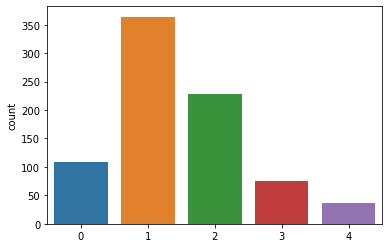

In [15]:
sns.countplot(target)
plt.show()

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X.full_text, target, test_size=0.33, stratify=target, random_state=15)

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, stratify=y_train, random_state=15)
x_test_val, x_test, y_test_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify=y_test, random_state=15)

In [18]:
print(f'x_train: {len(x_train)}')
print(f'x_val: {len(x_val)}')
print(f'x_test_val: {len(x_test_val)}')
print(f'x_test: {len(x_test)}')

x_train: 325
x_val: 218
x_test_val: 134
x_test: 134


In [19]:
vectorizers = (CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english'), HashingVectorizer(stop_words='english'))

for v in vectorizers:
    pipe = make_pipeline(v, XGBClassifier())
    pipe.fit(x_val, y_val)
    pipe_predict_proba = pipe.predict_proba(x_test_val)
    roc_score = roc_auc_score(y_test_val, pipe_predict_proba, average='weighted', multi_class='ovr')
    
    print('*******************************************************')
    print('{0}: {1}'.format(v, roc_score))
    print('*******************************************************\n')

*******************************************************
CountVectorizer(stop_words='english'): 0.73321669706783
*******************************************************

*******************************************************
TfidfVectorizer(stop_words='english'): 0.797410758200365
*******************************************************

*******************************************************
HashingVectorizer(stop_words='english'): 0.8530764119092927
*******************************************************



In [20]:
vectorizers = (CountVectorizer(), TfidfVectorizer(), HashingVectorizer())

for v in vectorizers:
    pipe = make_pipeline(v, XGBClassifier())
    pipe.fit(x_val, y_val)
    pipe_predict_proba = pipe.predict_proba(x_test_val)
    roc_score = roc_auc_score(y_test_val, pipe_predict_proba, average='weighted', multi_class='ovr')
    
    print('*******************************************************')
    print('{0}: {1}'.format(v, roc_score))
    print('*******************************************************\n')

*******************************************************
CountVectorizer(): 0.7448634636828053
*******************************************************

*******************************************************
TfidfVectorizer(): 0.8158307366830461
*******************************************************

*******************************************************
HashingVectorizer(): 0.8517977911937453
*******************************************************



In [32]:
xgb =  make_pipeline(TfidfVectorizer(), XGBClassifier())
xgb.fit(x_train, y_train)
predict_target = xgb.predict_proba(x_test)
roc_score = roc_auc_score(y_test, predict_target, average='weighted', multi_class='ovr')
print(f'roc-auc score: {roc_score:.5f}')
print(classification_report(y_test, xgb.predict(x_test)))

roc-auc score: 0.80364
              precision    recall  f1-score   support

           0       0.56      0.50      0.53        18
           1       0.67      0.77      0.71        60
           2       0.57      0.53      0.55        38
           3       0.23      0.25      0.24        12
           4       0.00      0.00      0.00         6

    accuracy                           0.58       134
   macro avg       0.41      0.41      0.41       134
weighted avg       0.56      0.58      0.57       134



In [26]:
def evaluate_model(model):
    cv = RepeatedStratifiedKFold(n_repeats=5)
    score = cross_val_score(model, x_val, y_val, cv=cv, n_jobs=-1)
    return score

100: 0.62649 (0.06224)
200: 0.62190 (0.07582)
300: 0.59543 (0.06470)
400: 0.61835 (0.05464)
500: 0.61376 (0.05003)


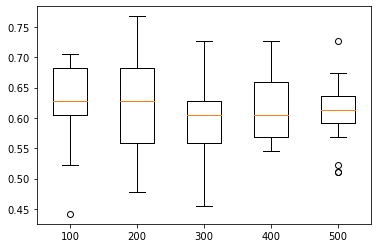

In [33]:
def get_models1():
    models = {}
    estimators= range(100, 501, 100)
    for e in estimators:
        models[str(e)] = make_pipeline(TfidfVectorizer(), XGBClassifier(n_estimators=e))
    return models

models1 = get_models1()
results, names = [], []
for name, model in models1.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    print(f'{name}: {np.mean(scores):.5f} ({np.std(scores):.5f})')

    
plt.boxplot(results, labels=names)
plt.show()

500: 0.61674 (0.06203)
1000: 0.60926 (0.04719)
1500: 0.62391 (0.05213)
2000: 0.60839 (0.05566)
2500: 0.62567 (0.05980)


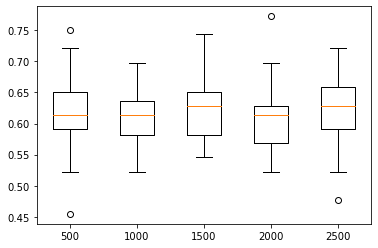

In [34]:
def get_models1():
    models = {}
    estimators= range(500, 2501, 500)
    for e in estimators:
        models[str(e)] = make_pipeline(TfidfVectorizer(), XGBClassifier(n_estimators=e))
    return models

models1 = get_models1()
results, names = [], []
for name, model in models1.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    print(f'{name}: {np.mean(scores):.5f} ({np.std(scores):.5f})')

    
plt.boxplot(results, labels=names)
plt.show()

7: 0.62641 (0.05262)
8: 0.61025 (0.05359)
9: 0.60835 (0.06567)
10: 0.60651 (0.04498)
11: 0.61201 (0.05425)
12: 0.61019 (0.05505)
13: 0.62372 (0.05649)
14: 0.63127 (0.05446)


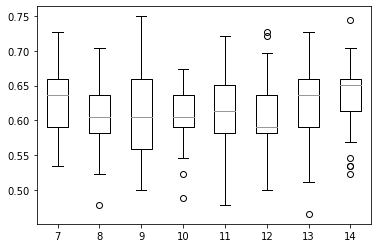

In [40]:
def get_models2():
    models = {}
    depth = range(7, 15)
    for d in depth:
        models[d] = make_pipeline(TfidfVectorizer(), XGBClassifier(n_estimators=2500, max_depth=d))
    return models

models2 = get_models2()
results, names = [], []
for name, model in models2.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    
    print(f'{name}: {np.mean(scores):.5f} ({np.std(scores):.5f})')

    
plt.boxplot(results, labels=names)
plt.show()

3: 0.62463 (0.05518)
4: 0.61839 (0.06303)
5: 0.63127 (0.05678)
6: 0.61567 (0.05122)
7: 0.62831 (0.05661)
8: 0.62283 (0.04964)
9: 0.62298 (0.05380)


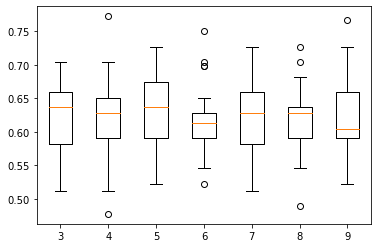

In [41]:
def get_models3():
    models = {}
    leaves = range(3,10)
    for l in leaves:
        models[str(l)] = make_pipeline(TfidfVectorizer(), XGBClassifier(n_estimators=2500, max_depth=7, max_leaves=2**l))
    return models

models3 = get_models3()
results, names = [], []
for name, model in models3.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print(f'{name}: {np.mean(scores):.5f} ({np.std(scores):.5f})')
    
plt.boxplot(results, labels=names)
plt.show()

In [47]:
xgb2 =  make_pipeline(TfidfVectorizer(), XGBClassifier(n_estimators=2500))
xgb2.fit(x_train, y_train)
predict_target2 = xgb2.predict_proba(x_test)
roc_score2 = roc_auc_score(y_test, predict_target2, average='weighted', multi_class='ovr')
print(f'roc-auc score: {roc_score2:.5f}')
print(classification_report(y_test, xgb2.predict(x_test)))

roc-auc score: 0.80259
              precision    recall  f1-score   support

           0       0.47      0.44      0.46        18
           1       0.64      0.73      0.68        60
           2       0.55      0.47      0.51        38
           3       0.21      0.25      0.23        12
           4       0.00      0.00      0.00         6

    accuracy                           0.54       134
   macro avg       0.37      0.38      0.38       134
weighted avg       0.52      0.54      0.53       134

